In [ ]:
!pip install torch torchvision
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import zipfile

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip

--2025-02-03 10:48:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.207, 142.250.98.207, 142.251.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   200MB/s    in 0.3s    

2025-02-03 10:48:43 (200 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
import zipfile
with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as zip_ref:

    zip_ref.extractall('/content/')

In [5]:
zip_ref=zipfile.ZipFile('/content/cats_and_dogs_filtered.zip','r')
zip_ref.extractall('./content')
zip_ref.close()
# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
cats_vs_dogs_dataset = ImageFolder(root='/content/cats_and_dogs_filtered', transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(cats_vs_dogs_dataset))
val_size = len(cats_vs_dogs_dataset) - train_size
train_dataset, val_dataset = random_split(cats_vs_dogs_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# Define transformations
transform_cifar = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
cifar10_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

# Split dataset into training and validation sets
train_size_cifar = int(0.8 * len(cifar10_dataset))
val_size_cifar = len(cifar10_dataset) - train_size_cifar
train_dataset_cifar, val_dataset_cifar = random_split(cifar10_dataset, [train_size_cifar, val_size_cifar])

# Create data loaders
train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=32, shuffle=True)
val_loader_cifar = DataLoader(val_dataset_cifar, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 77.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
class CNN(nn.Module):
    def __init__(self, activation_fn, weight_init):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)  # 2 classes for Cats vs. Dogs
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)

        # Activation function
        if activation_fn == 'relu':
            self.activation = F.relu
        elif activation_fn == 'tanh':
            self.activation = torch.tanh
        elif activation_fn == 'leaky_relu':
            self.activation = F.leaky_relu

        # Weight initialization
        if weight_init == 'xavier':
            nn.init.xavier_uniform_(self.conv1.weight)
            nn.init.xavier_uniform_(self.conv2.weight)
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
        elif weight_init == 'kaiming':
            nn.init.kaiming_uniform_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.conv2.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        elif weight_init == 'random':
            nn.init.normal_(self.conv1.weight, mean=0, std=0.01)
            nn.init.normal_(self.conv2.weight, mean=0, std=0.01)
            nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
            nn.init.normal_(self.fc2.weight, mean=0, std=0.01)

    def forward(self, x):
        x = self.pool(self.activation(self.batch_norm1(self.conv1(x))))
        x = self.pool(self.activation(self.batch_norm2(self.conv2(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.fc2(x)
        return x

In [8]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [10]:
activation_fns = ['relu', 'tanh', 'leaky_relu']
weight_inits = ['xavier', 'kaiming', 'random']
optimizers_list = ['sgd', 'adam', 'rmsprop']

results = {}

for activation_fn in activation_fns:
    for weight_init in weight_inits:
        for optimizer_name in optimizers_list:
            print(f'Training with Activation: {activation_fn}, Weight Init: {weight_init}, Optimizer: {optimizer_name}')

            # Initialize model
            model = CNN(activation_fn=activation_fn, weight_init=weight_init)

            # Define optimizer
            if optimizer_name == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
            elif optimizer_name == 'adam':
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            elif optimizer_name == 'rmsprop':
                optimizer = optim.RMSprop(model.parameters(), lr=0.001)

            # Define loss function
            criterion = nn.CrossEntropyLoss()

            # Train model
            train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=10)

            # Save results
            results[(activation_fn, weight_init, optimizer_name)] = {
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            }

Training with Activation: relu, Weight Init: xavier, Optimizer: sgd
Epoch 1/10, Train Loss: 0.8398, Train Acc: 61.08%, Val Loss: 0.6448, Val Acc: 65.50%
Epoch 2/10, Train Loss: 0.6386, Train Acc: 65.79%, Val Loss: 0.6646, Val Acc: 66.33%
Epoch 3/10, Train Loss: 0.6123, Train Acc: 67.33%, Val Loss: 0.6727, Val Acc: 65.67%
Epoch 4/10, Train Loss: 0.6007, Train Acc: 67.92%, Val Loss: 0.6761, Val Acc: 64.83%
Epoch 5/10, Train Loss: 0.5801, Train Acc: 69.71%, Val Loss: 0.6956, Val Acc: 63.17%
Epoch 6/10, Train Loss: 0.5646, Train Acc: 71.54%, Val Loss: 0.6793, Val Acc: 63.50%
Epoch 7/10, Train Loss: 0.5255, Train Acc: 73.46%, Val Loss: 0.6828, Val Acc: 61.67%
Epoch 8/10, Train Loss: 0.4897, Train Acc: 76.50%, Val Loss: 0.6934, Val Acc: 62.50%
Epoch 9/10, Train Loss: 0.4580, Train Acc: 78.29%, Val Loss: 0.7144, Val Acc: 61.50%
Epoch 10/10, Train Loss: 0.4345, Train Acc: 80.00%, Val Loss: 0.7363, Val Acc: 64.33%
Training with Activation: relu, Weight Init: xavier, Optimizer: adam
Epoch 1/10, 

In [11]:
# Load pretrained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the final layer for Cats vs. Dogs (2 classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)

# Define optimizer and loss function
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=0.001)
criterion_resnet = nn.CrossEntropyLoss()

# Train ResNet-18
train_losses_resnet, val_losses_resnet, train_accuracies_resnet, val_accuracies_resnet = train_model(resnet18, train_loader, val_loader, optimizer_resnet, criterion_resnet, num_epochs=10)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 53.9MB/s]


Epoch 1/10, Train Loss: 0.8764, Train Acc: 61.50%, Val Loss: 0.6408, Val Acc: 66.50%
Epoch 2/10, Train Loss: 0.6890, Train Acc: 66.38%, Val Loss: 0.6501, Val Acc: 65.50%
Epoch 3/10, Train Loss: 0.6513, Train Acc: 66.04%, Val Loss: 0.6688, Val Acc: 66.33%
Epoch 4/10, Train Loss: 0.6492, Train Acc: 66.00%, Val Loss: 0.6663, Val Acc: 64.67%
Epoch 5/10, Train Loss: 0.6189, Train Acc: 67.42%, Val Loss: 0.7170, Val Acc: 65.17%
Epoch 6/10, Train Loss: 0.5813, Train Acc: 70.38%, Val Loss: 0.7056, Val Acc: 64.00%
Epoch 7/10, Train Loss: 0.5783, Train Acc: 69.83%, Val Loss: 0.7416, Val Acc: 64.83%
Epoch 8/10, Train Loss: 0.5462, Train Acc: 73.33%, Val Loss: 1.0364, Val Acc: 60.33%
Epoch 9/10, Train Loss: 0.4784, Train Acc: 78.50%, Val Loss: 0.7720, Val Acc: 61.33%
Epoch 10/10, Train Loss: 0.3885, Train Acc: 83.04%, Val Loss: 0.9647, Val Acc: 54.17%


In [12]:
# Save the best model weights
torch.save(model.state_dict(), 'best_model_cats_vs_dogs.pth')
torch.save(resnet18.state_dict(), 'best_resnet18_cats_vs_dogs.pth')

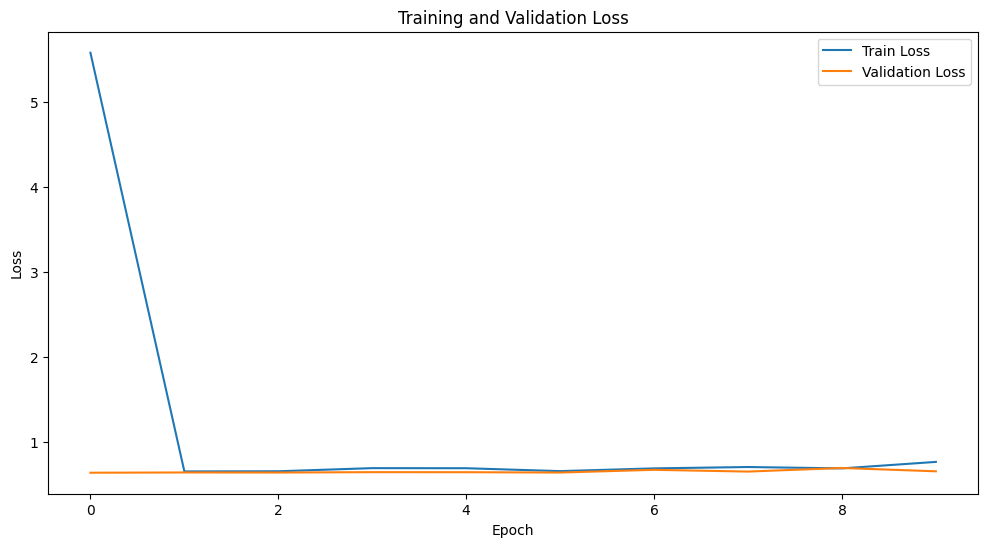

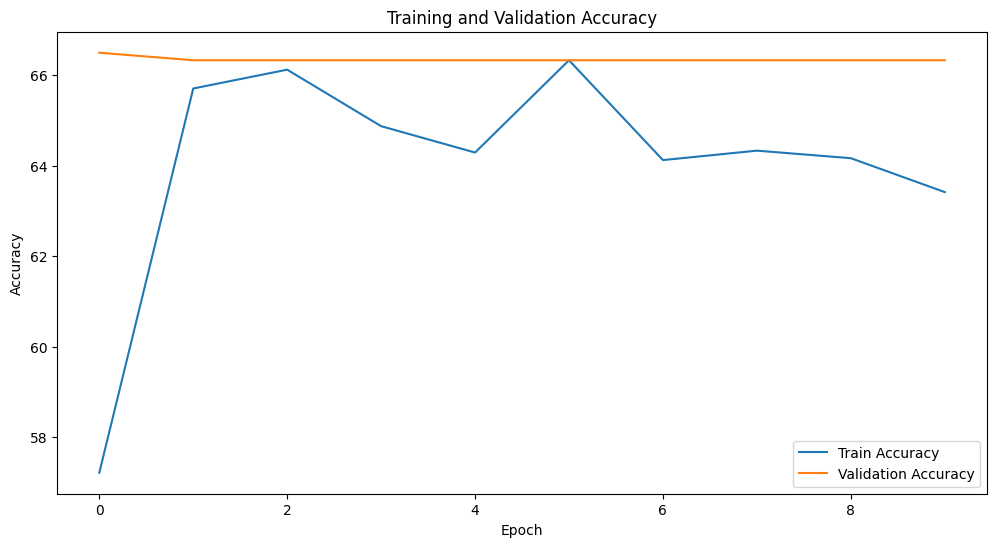

In [13]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [14]:
# Modify the final layer for CIFAR-10 (10 classes)
model.fc2 = nn.Linear(512, 10)